#TRAXIÓN: PRUEBA TÉCNICA

### Contexto:

Se desarrolla una **app móvil** para identificar las razones de **alta rotación de conductores**. La app contiene **quejas** etiquetadas según el **área** (finanzas, RH, y operaciones). La app contiene **variables** como: experiencia de viaje, evaluación del conductor, o cualquier otra que se considere de utilidad y sea sensata.

### Planteamiento:

Fruto de la pandemia de COVID hay una fuerte demanda de conductores. La gran mayoría de conductores que renuncian [no cambian de industria]((https://www.trucking.org/news-insights/truth-about-trucking-turnover), sino que cambian de patrón a cambio de incrementos salaries y/o bonos. Según la [CANACAR](https://canacar.com.mx/este-plan-canacar-reducir-deficit-operadores/), en México también tenemos este déficit. La demanda de conductores genera presiones inflacionarias que resultan en "pirataje de conductores".

De acuerdo a la CANACAR estas son algunas de las principales causas de rotación:

*   Sobrecarga laboral y largas jornadas
*   Baja remuneración y falta de incentivos
*   Escasas oportunidades de capacitación y desarrollo profesional
*   Condiciones laborales desfavorables
*   Competencia en el mercado y migración de talento

Teniendo esto en cuenta, se propone que la aplicación contenga las siguientes
variables:

Registradas en la app:

- ID de la queja
- ID del conductor
- Fecha y hora en la que se registró la queja
- Área de la queja (Finanzas, Recursos Humanos u Operaciones)
- Descripción (Texto libre, máximo 250 caracteres)

Datos del conductor

- ID del conductor
- Edad
- Años de experiencia en la industria del transporte
- Fecha de contratación
- Salario
- Cantidad de viajes realizados
- KM recorridos totales
- Tiempo de inactividad total en viajes (en minutos)
- Número de incidentes de riesgo (asaltos, robos)
- Estado de contrato (Activo, Baja)

## Generación de datos

### Datos de los conductores

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Hay entre 4000 y 5000 empleados contratados
np.random.seed(42) # Semilla para que la generación sea reproducible
n = np.random.randint(4000,5000, size = 1)[0]

# Crear el dataframe
df = pd.DataFrame()

# Edad, 66% entre 32 y 48, 96% entre 24 y 56, 100% entre 20 y 60
df['Edad'] = np.random.normal(loc=40, scale=8, size=n)
df['Edad'] = np.clip(df['Edad'], 20, 60).astype(int)

# Fecha de contratación, depende de la edad
def generar_fecha_contratacion(edad):
    max = min(edad - 19, 30)
    año_contratacion = np.random.uniform(1, max, size = 1)[0]
    fecha_contratacion = pd.to_datetime('03/01/2025') - relativedelta(days = int(año_contratacion*365))
    return fecha_contratacion

df['Fecha contratacion'] = df['Edad']-20
df['Fecha contratacion'] = df['Edad'].apply(generar_fecha_contratacion)

# Años de experiencia en la industria del transporte, depende de la edad
def generar_exp(edad):
    max = edad - 19
    exp = int(np.random.uniform(0, max, size = 1)[0])
    return exp

df['Años de experiencia'] = df['Edad'].apply(generar_exp)

# Cantidad de viajes realizados, depende de la fecha de contratación
def generar_viajes(contratacion):
   duracion = (pd.to_datetime('03/01/2025') - contratacion).days
   duracion = int(duracion*np.random.uniform(.5, .9, size = 1)[0])
   return duracion

df['Viajes realizados'] = df['Fecha contratacion'].apply(generar_viajes)

# KM recorridos totales, depende de la fecha de contratación
df['Km totales recorridos'] = (pd.to_datetime('03/01/2025') - df['Fecha contratacion']).dt.days
df['Km totales recorridos'] = (df['Km totales recorridos']*np.random.normal(loc=350, scale=80, size=n)).astype(int)

# Tiempo de inactividad, depende de los viajes realizados y sus km totales recorridos
df['Tiempo de inactividad total'] = (df['Viajes realizados'] * df['Km totales recorridos'])/(pd.to_datetime('03/01/2025') - df['Fecha contratacion']).dt.days
df['Tiempo de inactividad total'] = (1.1 - df['Tiempo de inactividad total']/max(df['Tiempo de inactividad total']))*np.random.normal(loc=60, scale=15, size=n)
df['Tiempo de inactividad total'] = (df['Tiempo de inactividad total']*df['Viajes realizados']).astype(int)

# Numero de incidentes, depende de los viajes realizados
df['Incidentes de peligro'] = (df['Viajes realizados']*np.random.beta(1, 3000, size=n)).astype(int)



### Comentarios generados por IA

In [61]:
import pandas as pd
# Importar los datos con los comentarios
comentarios = pd.read_csv('comentarios_texto.csv', encoding ='latin1')

# Guardar los comentarios como listas
comentarios['Comentarios'] = comentarios['Comentarios'].apply(lambda x: eval(x))

# Obtener la longitud de cada listas
comentarios['longitud'] = comentarios['Comentarios'].apply(lambda x: len(x))

In [62]:
comentarios

,Area,Positividad,Modelo,Comentarios,longitud
0,Finanzas,0.50,GPT 4,"[El pago llegó, pero tardó más de lo esperado,...",225
1,Finanzas,0.25,GPT 4,[El pago de esta semana fue más bajo de lo esp...,329
2,Finanzas,0.00,GPT 4,"[Me descontaron dinero sin explicación, No rec...",335
3,RH,0.50,GPT 4,[El supervisor no escucha nuestras preocupacio...,294
4,RH,0.25,GPT 4,[El supervisor no escucha nuestras preocupacio...,275
5,RH,0.00,GPT 4,[El trato del personal administrativo es pésim...,291
6,Operaciones,0.50,GPT 4,"[El vehículo asignado tenía fallas mecánicas, ...",316
7,Operaciones,0.25,GPT 4,[El vehículo asignado tenía un problema con lo...,330
8,Operaciones,0.00,GPT 4,"[El viaje estuvo mal planificado, tuve que esp...",299


In [4]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 40.6 MB/s eta 0:00:00


In [23]:
from spellchecker import SpellChecker
spanish = SpellChecker(language='es')

comentario = finanzas_05[-1]
print(comentario.split())

misspelled = spanish.unknown(comentario.split())

for word in misspelled:
    # Get the one `most likely` answer
    print(spanish.correction(word))

    # Get a list of `likely` options
    print(spanish.candidates(word))

['No', 'puedo', 'hacer', 'el', 'depósito', 'Repeat', 'Diez.']
diez
{'diez'}
repente
{'repeso', 'reptar', 'repente', 'repleta', 'repeor', 'repelo', 'receta', 'ropeta', 'repelar', 'repesar'}
quedo
{'ruedo', 'quedo', 'puado', 'pedo'}


In [ ]:
print(df.head().to_markdown(index=False))
print(df.info())

|   Edad | Fecha contratacion   |   Años de experiencia |   Viajes realizados |   Km totales recorridos |   Tiempo de inactividad total |   Incidentes de peligro |
|-------:|:---------------------|----------------------:|--------------------:|------------------------:|------------------------------:|------------------------:|
|     35 | 2010-04-27 00:00:00  |                    10 |                4381 |                 2475443 |                        235338 |                       1 |
|     44 | 2000-03-29 00:00:00  |                    15 |                5901 |                 3244435 |                        206697 |                       3 |
|     43 | 2023-06-03 00:00:00  |                     0 |                 504 |                  198166 |                         31401 |                       0 |
|     50 | 2017-05-04 00:00:00  |                    16 |                1898 |                 1109687 |                         92920 |                       0 |
|     32 | 2020-

<Axes: ylabel='Frequency'>

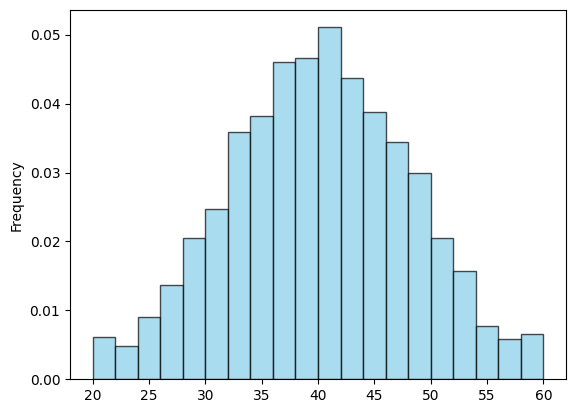

In [ ]:
df['Edad'].plot(kind='hist', bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.7)